In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
import pickle as pkl
from descartes import PolygonPatch

import requests
import pandas as pd
import feedparser
from bs4 import BeautifulSoup
import urllib.request
import urllib3
import json
from pandas.io.json import json_normalize
import numpy as np

In [49]:
crs = {'init': 'epsg:4326'}
surl = 'https://services.arcgis.com/lQySeXwbBg53XWDi/arcgis/rest/services/Wastewater_Study_Areas/FeatureServer/0/query?where=OBJECTID+%3E+0+&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&resultType=none&distance=0.0&units=esriSRUnit_Meter&returnGeodetic=false&outFields=*&returnGeometry=true&returnCentroid=false&featureEncoding=esriDefault&multipatchOption=xyFootprint&maxAllowableOffset=&geometryPrecision=&outSR=4326&datumTransformation=&applyVCSProjection=false&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&returnQueryGeometry=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&returnZ=false&returnM=false&returnExceededLimitFeatures=true&quantizationParameters=&sqlFormat=none&f=pgeojson&token='
sa = gpd.read_file(surl)
sa.dtypes

OBJECTID            int64
Site               object
Shape__Area       float64
Shape__Length     float64
geometry         geometry
dtype: object

In [50]:
sa.drop(['OBJECTID'], axis=1, inplace=True)

In [51]:
sa = sa[sa['Site'] != 'TP01']
sa = sa[sa['Site'] != 'TP03']

In [5]:
def buffer_mi(df, miles):
    """takes geopandas dataframe and returns a buffer of miles from that point/polygon
    Args:
        df (geopandas dataframe) - geopandas dataframe to convert
        mile - number of miles that buffer is from points in geometry  
    Returns:
        convertedDF - new geopandas dataframe that has a polygon that is m miles buffer from original geometry
    """
    #Getting mile buffer for the outside of Tempe
    convertedDF = df.to_crs({'init': 'epsg:3174'})
    
    #converting from miles to meters
    buffer_length_in_meters = (miles * 1000) * 1.60934
    convertedDF['geometry'] = convertedDF.geometry.buffer(buffer_length_in_meters)

    convertedDF = convertedDF.to_crs({'init': 'epsg:4326'})
    
    convertedDF.reset_index(inplace=True)
    convertedDF.drop(['index'], axis=1, inplace=True)
    return(convertedDF)

In [52]:
sa_bdry = buffer_mi(sa, 0.5)
sa_bdry.head()
sa_bdry.dtypes

Site               object
Shape__Area       float64
Shape__Length     float64
geometry         geometry
dtype: object

In [12]:
crs = {'init': 'epsg:4326'}
turl = 'https://services.arcgis.com/lQySeXwbBg53XWDi/arcgis/rest/services/City_Boundary/FeatureServer/0/query?where=OBJECTID+%3E+0+&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&resultType=none&distance=0.0&units=esriSRUnit_Meter&returnGeodetic=false&outFields=*&returnGeometry=true&returnCentroid=false&featureEncoding=esriDefault&multipatchOption=xyFootprint&maxAllowableOffset=&geometryPrecision=&outSR=4326&datumTransformation=&applyVCSProjection=false&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&returnQueryGeometry=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&returnZ=false&returnM=false&returnExceededLimitFeatures=true&quantizationParameters=&sqlFormat=none&f=pgeojson&token='
bdry = gpd.read_file(turl)

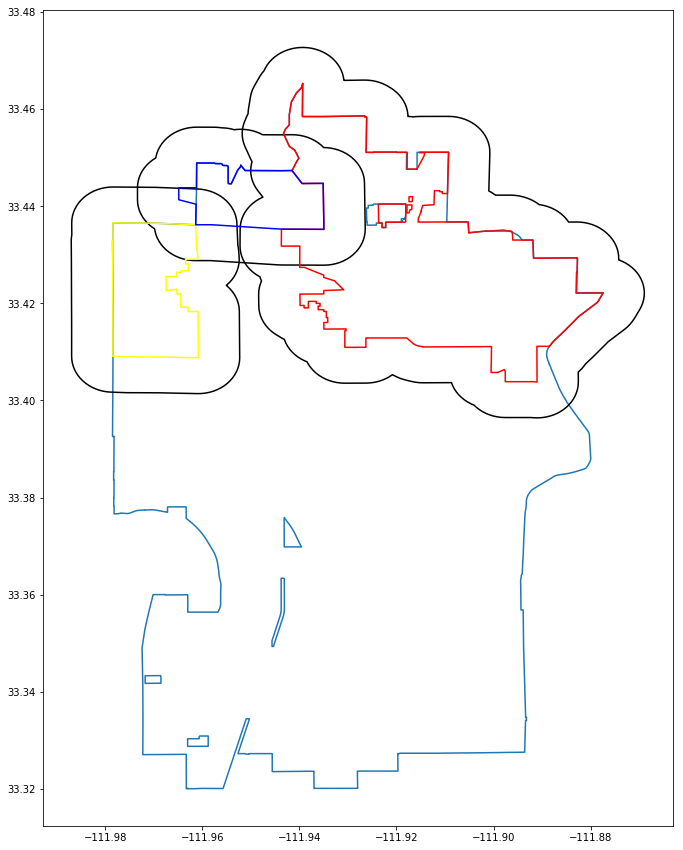

In [53]:
fig, ax = plt.subplots(figsize=(15,15))
bdry.boundary.plot(ax=ax)
sa_bdry.boundary.plot(ax=ax, color='black')
sa[sa['Site'] == 'TP02'].boundary.plot(ax=ax, color='red')
sa[sa['Site'] == 'TP04'].boundary.plot(ax=ax, color = 'yellow')
sa[sa['Site'] == 'TP05'].boundary.plot(ax=ax, color = 'blue')

In [44]:
facilities = pd.read_csv('DataFiles/FacilityData/MedicalFacilitiesWithin2milesTempeFULL.csv')
facilities.head()

,Unnamed: 0,Name,Type,Subtype,Category,Capacity,Address,City,County,Zip,Lat,Lon,Layer,geometry,CountCategory
0,0,ARIZONA SPECIALTY HOSPITAL,HOSPITAL,SHORT TERM,HOSPITAL,24,"2905 WEST WARNER ROAD, SUITE 1",CHANDLER,MARICOPA,85224,33.334700,-111.891218,Hospital,POINT (-111.891218 33.3347),HospitalsGeneral
1,1,BANNER DESERT MEDICAL CENTER,HOSPITAL,SHORT TERM,HOSPITAL,615,1400 SOUTH DOBSON ROAD,MESA,MARICOPA,85202,33.390773,-111.874786,Hospital,POINT (-111.874786 33.390773),HospitalsGeneral
2,2,SCOTTSDALE OSBORN MEDICAL CENTER,HOSPITAL,SHORT TERM,HOSPITAL,341,7400 EAST OSBORN ROAD,SCOTTSDALE,MARICOPA,85251,33.487776,-111.922888,Hospital,POINT (-111.922888 33.487776),HospitalsGeneral
3,3,O.A.S.I.S. HOSPITAL,HOSPITAL,SHORT TERM,HOSPITAL,64,750 NORTH 40TH STREET,PHOENIX,MARICOPA,85008,33.456559,-111.995377,Hospital,POINT (-111.995377 33.456559),HospitalsGeneral
4,4,"TEMPE ST LUKE'S HOSPITAL, A CAMPUS OF ST LUKE'...",HOSPITAL,SHORT TERM,HOSPITAL,74,1500 SOUTH MILL AVENUE,TEMPE,MARICOPA,85281,33.412378,-111.940084,Hospital,POINT (-111.940084 33.412378),HospitalsGeneral


In [45]:
def create_geo_df_mf(df):
    """takes url and returns geopandas dataframe used for the Medical facilities.
    Args:
        url - queried from ArcGIS
        layer - name of the feature layer data was pulled from
    Returns:
        geo_df - new geopandas dataframe from that url
    """
    crs = {'init': 'epsg:4326'}
    
    sa_med = pd.DataFrame(df)
    sa_med.drop(['Unnamed: 0'], axis=1, inplace=True)
    
    geometry = [Point(xy) for xy in zip(sa_med['Lon'],sa_med['Lat'])]

    geo_df = gpd.GeoDataFrame(sa_med, crs = crs, geometry = geometry)
    
    return(geo_df)

In [46]:
facilities = create_geo_df_mf(facilities)

In [38]:
from osgeo import ogr
def counting_facilities(df_2mi):
    """takes geopandas dataframe and returns the points that are within the Tempe buffer
    Args:
        convertedDF (geopandas dataframe) - mile buffer geopandas dataframe to count facilities from
    Returns:
        medfCounts (lst) - list of the number of facility buffer polygons 
                            (an m mile ring from the facility location) that 
                            contain the centroid of the census tract
    """
    df_2mi.reset_index(inplace=True)
    df_2mi.drop(['index'], axis=1, inplace=True)
    counts = {}
    medCounts = []
    n = len(df_2mi)-1
    for i in range(len(sa_bdry)):
        loc1 = sa_bdry.loc[i,'geometry']
        name = sa_bdry.loc[i, 'Site']
        fCount = 0
        for j in range(len(df_2mi)):
            loc2 = df_2mi.loc[j,'geometry']
            intersection = loc1.contains(loc2)
            if intersection == True:
                fCount += 1
            if j == n:
                counts[name] = fCount
                medCounts.append(fCount)
    print(counts)
    return(medCounts)

In [28]:
np.unique(facilities['CountCategory'])



array(['ChildFacilities', 'Hospice', 'HospitalsGeneral', 'HospitalsPsych',
       'MedicalFacility', 'MentalFacilities', 'NursingAssisted',
       'PainManagement', 'PhysicalTherapy', 'SubstanceHelp',
       'SurgicalCenters', 'UrgentCare', 'WomensClinic'], dtype=object)

In [54]:
hospitals_gen = facilities[facilities['CountCategory'] == 'HospitalsGeneral']
hospitals_ment = facilities[facilities['CountCategory'] == 'HospitalsPsych']
surgical_centers = facilities[facilities['CountCategory'] == 'SurgicalCenters']
urgent_care = facilities[facilities['CountCategory'] == 'UrgentCare']
womens_clinics = facilities[facilities['CountCategory'] == 'WomensClinic']
pain_management = facilities[facilities['CountCategory'] == 'PainManagement']
physical_therapy = facilities[facilities['CountCategory'] == 'PhysicalTherapy']
mental_facilities = facilities[facilities['CountCategory'] == 'MentalFacilities']
substance_help = facilities[facilities['CountCategory'] == 'SubstanceHelp']
med_2mi = facilities[facilities['CountCategory'] == 'MedicalFacility']
nursing_assisted = facilities[facilities['CountCategory'] == 'NursingAssisted']
hospice_centers = facilities[facilities['CountCategory'] == 'Hospice']
child_facilities = facilities[facilities['CountCategory'] == 'ChildFacilities']

In [61]:
medFacCendf = pd.DataFrame()
medFacCendf['TempeSite_Name'] = sa['Site']
medFacCendf['HospitalsGeneralCount0.5mi'] = counting_facilities(hospitals_gen)
medFacCendf['HospitalsPsychCount0.5mi'] = counting_facilities(hospitals_ment)
medFacCendf['SurgicalCentersCount0.5mi'] = counting_facilities(surgical_centers)
medFacCendf['UrgentCareCount0.5mi'] = counting_facilities(urgent_care)
medFacCendf['WomensClinicsCount0.5mi'] = counting_facilities(womens_clinics)
medFacCendf['PainManagementCoun0.5mi'] = counting_facilities(pain_management)
medFacCendf['PhysicalTherapyCount0.5mi'] = counting_facilities(physical_therapy)
medFacCendf['MentalFacilitiesCount0.5mi'] = counting_facilities(mental_facilities)
medFacCendf['SubstanceAbuseCount0.5mi'] = counting_facilities(substance_help)
medFacCendf['OtherMedicalFacilitesCount0.5mi'] = counting_facilities(med_2mi)
medFacCendf['NursingAssistedLiveCount0.5mi'] = counting_facilities(nursing_assisted)
medFacCendf['HospiceCount0.5mi'] = counting_facilities(hospice_centers)
medFacCendf['ChildFacilitiesCount0.5mi'] = counting_facilities(child_facilities)
medFacCendf

/Users/maddiewarndorf/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


{'TP04': 0, 'TP05': 0, 'TP02': 1}
{'TP04': 0, 'TP05': 0, 'TP02': 0}
{'TP04': 0, 'TP05': 0, 'TP02': 0}
{'TP04': 0, 'TP05': 0, 'TP02': 0}
{'TP04': 0, 'TP05': 0, 'TP02': 0}
{'TP04': 0, 'TP05': 1, 'TP02': 1}
{'TP04': 0, 'TP05': 0, 'TP02': 1}
{'TP04': 1, 'TP05': 1, 'TP02': 3}
{'TP04': 0, 'TP05': 0, 'TP02': 2}
{'TP04': 6, 'TP05': 1, 'TP02': 6}
{'TP04': 1, 'TP05': 0, 'TP02': 2}
{'TP04': 1, 'TP05': 0, 'TP02': 0}
{'TP04': 0, 'TP05': 0, 'TP02': 1}


,TempeSite_Name,HospitalsGeneralCount0.5mi,HospitalsPsychCount0.5mi,SurgicalCentersCount0.5mi,UrgentCareCount0.5mi,WomensClinicsCount0.5mi,PainManagementCoun0.5mi,PhysicalTherapyCount0.5mi,MentalFacilitiesCount0.5mi,SubstanceAbuseCount0.5mi,OtherMedicalFacilitesCount0.5mi,NursingAssistedLiveCount0.5mi,HospiceCount0.5mi,ChildFacilitiesCount0.5mi
1,TP04,0,0,0,0,0,0,0,1,0,6,1,1,0
2,TP05,0,0,0,0,0,1,0,1,0,1,0,0,0
4,TP02,1,0,0,0,0,1,1,3,2,6,2,0,1


In [57]:
url='https://services1.arcgis.com/mpVYz37anSdrK4d8/ArcGIS/rest/services/Pharmacies/FeatureServer/0/query?where=N_COUNTY+%3D+%27MARICOPA+COUNTY%27&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&resultType=none&distance=0.0&units=esriSRUnit_Meter&returnGeodetic=false&outFields=*&returnGeometry=false&featureEncoding=esriDefault&multipatchOption=xyFootprint&maxAllowableOffset=&geometryPrecision=&outSR=&datumTransformation=&applyVCSProjection=false&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&returnQueryGeometry=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&returnZ=false&returnM=false&returnExceededLimitFeatures=true&quantizationParameters=&sqlFormat=none&f=pjson&token='
resp = requests.get(url)
print(resp)

data_raw = resp.json()

p_data = pd.io.json.json_normalize(data_raw['features'])

desired_cols = ['attributes.Business_N','attributes.Type_',
               'attributes.SubType_',
               'attributes.City',
               'attributes.N_ZIP','attributes.N_LAT',
               'attributes.N_LON']

p_df = p_data[desired_cols]

p_df.columns =['Name','Type','Subtype','City',
                'Zip','Lat','Lon']

tempe_p = pd.DataFrame(p_df)

geometry = [Point(xy) for xy in zip(tempe_p['Lon'],tempe_p['Lat'])]


geo_p = gpd.GeoDataFrame(tempe_p, crs = crs, geometry = geometry)
geo_p.head()

<Response [200]>


,Name,Type,Subtype,City,Zip,Lat,Lon,geometry
0,Walgreens Drug #01272,Pharmacy,Chain,Phoenix,85031,33.494732,-112.169111,POINT (-112.16911 33.49473)
1,Scottsdale Osborn Medical Center Pharmacy,Pharmacy,Hospital,Scottsdale,85251,33.487776,-111.922888,POINT (-111.92289 33.48778)
2,Walgreens Drug #16082,Pharmacy,Chain,Phoenix,85028,33.582619,-112.013259,POINT (-112.01326 33.58262)
3,Walgreens Drug #01197,Pharmacy,Chain,Tempe,85282,33.392813,-111.910238,POINT (-111.91024 33.39281)
4,Walgreens Drug #03593,Pharmacy,Chain,Phoenix,85023,33.611118,-112.111889,POINT (-112.11189 33.61112)


In [58]:
turl = 'https://services.arcgis.com/lQySeXwbBg53XWDi/arcgis/rest/services/City_Boundary/FeatureServer/0/query?where=OBJECTID+%3E+0+&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&resultType=none&distance=0.0&units=esriSRUnit_Meter&returnGeodetic=false&outFields=*&returnGeometry=true&returnCentroid=false&featureEncoding=esriDefault&multipatchOption=xyFootprint&maxAllowableOffset=&geometryPrecision=&outSR=4326&datumTransformation=&applyVCSProjection=false&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&returnQueryGeometry=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&returnZ=false&returnM=false&returnExceededLimitFeatures=true&quantizationParameters=&sqlFormat=none&f=pgeojson&token='
bdry = gpd.read_file(turl)
bndryConvertedB = buffer_mi(bdry, 2)

def facility_within_tempebuffer(geo_df, tempebuffer):
    """takes geopandas dataframe and returns the points that are within the Tempe buffer
    Args:
        geo_df (geopandas dataframe) - geopandas dataframe to pull points from
        tempebuffer - geopandas dataframe made of the Tempe city mile buffer
    Returns:
        df_mi - new geopandas dataframe that the points within the Tempe buffer
    """
    df_mi = pd.DataFrame()
    for i in range(len(tempebuffer)):
        df = geo_df[geo_df.within(tempebuffer.loc[i,'geometry'])]
        df_mi = df_mi.append(df)
    df_mi.reset_index(inplace=True)
    df_mi.drop(['index'], axis=1, inplace=True)
    return(df_mi)

geo_p = facility_within_tempebuffer(geo_p, bndryConvertedB)

In [62]:
medFacCendf['PharmCount0.5mi'] = counting_facilities(geo_p)

medFacCendf.head()

{'TP04': 6, 'TP05': 0, 'TP02': 12}


,TempeSite_Name,HospitalsGeneralCount0.5mi,HospitalsPsychCount0.5mi,SurgicalCentersCount0.5mi,UrgentCareCount0.5mi,WomensClinicsCount0.5mi,PainManagementCoun0.5mi,PhysicalTherapyCount0.5mi,MentalFacilitiesCount0.5mi,SubstanceAbuseCount0.5mi,OtherMedicalFacilitesCount0.5mi,NursingAssistedLiveCount0.5mi,HospiceCount0.5mi,ChildFacilitiesCount0.5mi,PharmCount0.5mi
1,TP04,0,0,0,0,0,0,0,1,0,6,1,1,0,6
2,TP05,0,0,0,0,0,1,0,1,0,1,0,0,0,0
4,TP02,1,0,0,0,0,1,1,3,2,6,2,0,1,12


In [60]:
url = 'https://services1.arcgis.com/mpVYz37anSdrK4d8/arcgis/rest/services/DrugDropOffLocations/FeatureServer/0/query?where=N_COUNTY+%3D+%27MARICOPA+COUNTY%27&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&resultType=none&distance=0.0&units=esriSRUnit_Meter&returnGeodetic=false&outFields=*&returnGeometry=false&featureEncoding=esriDefault&multipatchOption=xyFootprint&maxAllowableOffset=&geometryPrecision=&outSR=&datumTransformation=&applyVCSProjection=false&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&returnQueryGeometry=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&returnZ=false&returnM=false&returnExceededLimitFeatures=true&quantizationParameters=&sqlFormat=none&f=pjson&token='
resp = requests.get(url)
print(resp)

data_raw = resp.json()

dd_data = pd.io.json.json_normalize(data_raw['features'])

desired_cols = ['attributes.Location',
               'attributes.N_CITY',
               'attributes.N_ZIP','attributes.N_LAT',
               'attributes.N_LON']

dd_df = dd_data[desired_cols]

dd_df.columns =['Location','City',
                'Zip','Lat','Lon']

tempe_dd = pd.DataFrame(dd_df)

geometry = [Point(xy) for xy in zip(tempe_dd['Lon'],tempe_dd['Lat'])]


geo_dd = gpd.GeoDataFrame(tempe_dd, crs = crs, geometry = geometry)
geo_dd.head()

<Response [200]>


,Location,City,Zip,Lat,Lon,geometry
0,"Mountain Park Health Center, Maryvale",PHOENIX,85033,33.480216,-112.200886,POINT (-112.20089 33.48022)
1,Buckeye Police Department,BUCKEYE,85326,33.435517,-112.517596,POINT (-112.51760 33.43552)
2,Chandler Police Department,CHANDLER,85225,33.300739,-111.838065,POINT (-111.83807 33.30074)
3,Chandler Police Department Substation,CHANDLER,85249,33.233931,-111.770888,POINT (-111.77089 33.23393)
4,El Mirage Police Department,EL MIRAGE,85335,33.574272,-112.326009,POINT (-112.32601 33.57427)


In [63]:
drug_mi = facility_within_tempebuffer(geo_dd, bndryConvertedB)
medFacCendf['DrugDropCount0.5mi'] = counting_facilities(drug_mi)

medFacCendf.head()

{'TP04': 0, 'TP05': 0, 'TP02': 4}


,TempeSite_Name,HospitalsGeneralCount0.5mi,HospitalsPsychCount0.5mi,SurgicalCentersCount0.5mi,UrgentCareCount0.5mi,WomensClinicsCount0.5mi,PainManagementCoun0.5mi,PhysicalTherapyCount0.5mi,MentalFacilitiesCount0.5mi,SubstanceAbuseCount0.5mi,OtherMedicalFacilitesCount0.5mi,NursingAssistedLiveCount0.5mi,HospiceCount0.5mi,ChildFacilitiesCount0.5mi,PharmCount0.5mi,DrugDropCount0.5mi
1,TP04,0,0,0,0,0,0,0,1,0,6,1,1,0,6,0
2,TP05,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0
4,TP02,1,0,0,0,0,1,1,3,2,6,2,0,1,12,4


In [68]:
def create_geo_df_mf(df):
    """takes url and returns geopandas dataframe used for the Medical facilities.
    Args:
        url - queried from ArcGIS
        layer - name of the feature layer data was pulled from
    Returns:
        geo_df - new geopandas dataframe from that url
    """
    crs = {'init': 'epsg:4326'}
    
    sa_med = pd.DataFrame(df)
    sa_med.drop(['Unnamed: 0'], axis=1, inplace=True)
    
    geometry = [Point(xy) for xy in zip(sa_med['Long'],sa_med['Lat'])]

    geo_df = gpd.GeoDataFrame(sa_med, crs = crs, geometry = geometry)
    
    return(geo_df)

In [69]:
nal_mi = pd.read_csv('DataFiles/TEMPENaloxone2miles.csv')
geo_nal = create_geo_df_mf(nal_mi)

In [70]:
medFacCendf['NaloxoneDistribCount0.5mi'] = counting_facilities(geo_nal)

medFacCendf.head()

{'TP04': 0, 'TP05': 0, 'TP02': 5}


,TempeSite_Name,HospitalsGeneralCount0.5mi,HospitalsPsychCount0.5mi,SurgicalCentersCount0.5mi,UrgentCareCount0.5mi,WomensClinicsCount0.5mi,PainManagementCoun0.5mi,PhysicalTherapyCount0.5mi,MentalFacilitiesCount0.5mi,SubstanceAbuseCount0.5mi,OtherMedicalFacilitesCount0.5mi,NursingAssistedLiveCount0.5mi,HospiceCount0.5mi,ChildFacilitiesCount0.5mi,PharmCount0.5mi,DrugDropCount0.5mi,NaloxoneDistribCount0.5mi
1,TP04,0,0,0,0,0,0,0,1,0,6,1,1,0,6,0,0
2,TP05,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0
4,TP02,1,0,0,0,0,1,1,3,2,6,2,0,1,12,4,5


In [71]:
with open('DataFiles/countMedicalFacilitiesWithin0.5milesTempeBySiteFULL.pkl', 'wb') as pkl_file:
    pkl.dump(medFacCendf, pkl_file)

#medFacCendf.to_csv(r'DataFiles/cntMedicalFacilitiesWithin2milesTempeByTract.csv')

medFacCendf.to_csv(r'TEMPEcntMedicalFacilitiesWithin0.5milesBySite.csv')
